In [1]:
import json
import torch
import ast
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('..')
from auto_eval_utils import registered_simple_metrics, registered_helpers
from model import HeadOutputs
from datasets import load_from_disk, Dataset
from tqdm import tqdm

/home/connor/miniconda3/envs/lmsys/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
process_head_output = registered_helpers["p2l"]["output_labels"]
loss_func = registered_simple_metrics["bag"]["Loss"]

def convert_to_list(label_str):
    if isinstance(label_str, str):
        cleaned = label_str.strip('[]').split()
        return [int(x) for x in cleaned if x]
    elif isinstance(label_str, list):
        return label_str
    else:
        return []
    
def parse_eval_output_data(
    path,
    loss_type,
):
    df = pd.read_json(path)
    df = df.rename(columns={"coefs": "betas"})

    df["eta"] = df["eta"].apply(lambda x: x[0] if isinstance(x, list) else x)
    df["betas"] = df["betas"].apply(lambda x: x[0] if isinstance(x, list) else x)
    df['labels'] = df['labels'].apply(convert_to_list)
    ret_df = df

    preprocess_func = registered_helpers[loss_type]["preprocess_data"]
    ret_df = preprocess_func(data=ret_df)
    return ret_df

# Calculate Loss

In [74]:
model_cp_results = {}

def extract_loss(base, output_file):
    base = '/tmp/output_eps_0.016'
    for sub_path in tqdm(os.listdir(base)):
        checkpoint_folder = os.path.join(base, sub_path)
        if os.path.isdir(checkpoint_folder):
            cp_num = int(sub_path.split('-')[-1])
            model_cp_results[cp_num] = {}
            for base_file in os.listdir(checkpoint_folder):
                dataset_num = int(base_file.split('.')[0].split('-')[-1])    
                file_path = os.path.join(checkpoint_folder, base_file)
                df = parse_eval_output_data(file_path, "bag")
                head_out, labels = process_head_output(df)
                loss = loss_func(head_out, labels, "bag")
                model_cp_results[cp_num][dataset_num] = loss
                

    with open(output_file, 'w') as file:
        json.dump(model_cp_results, file)


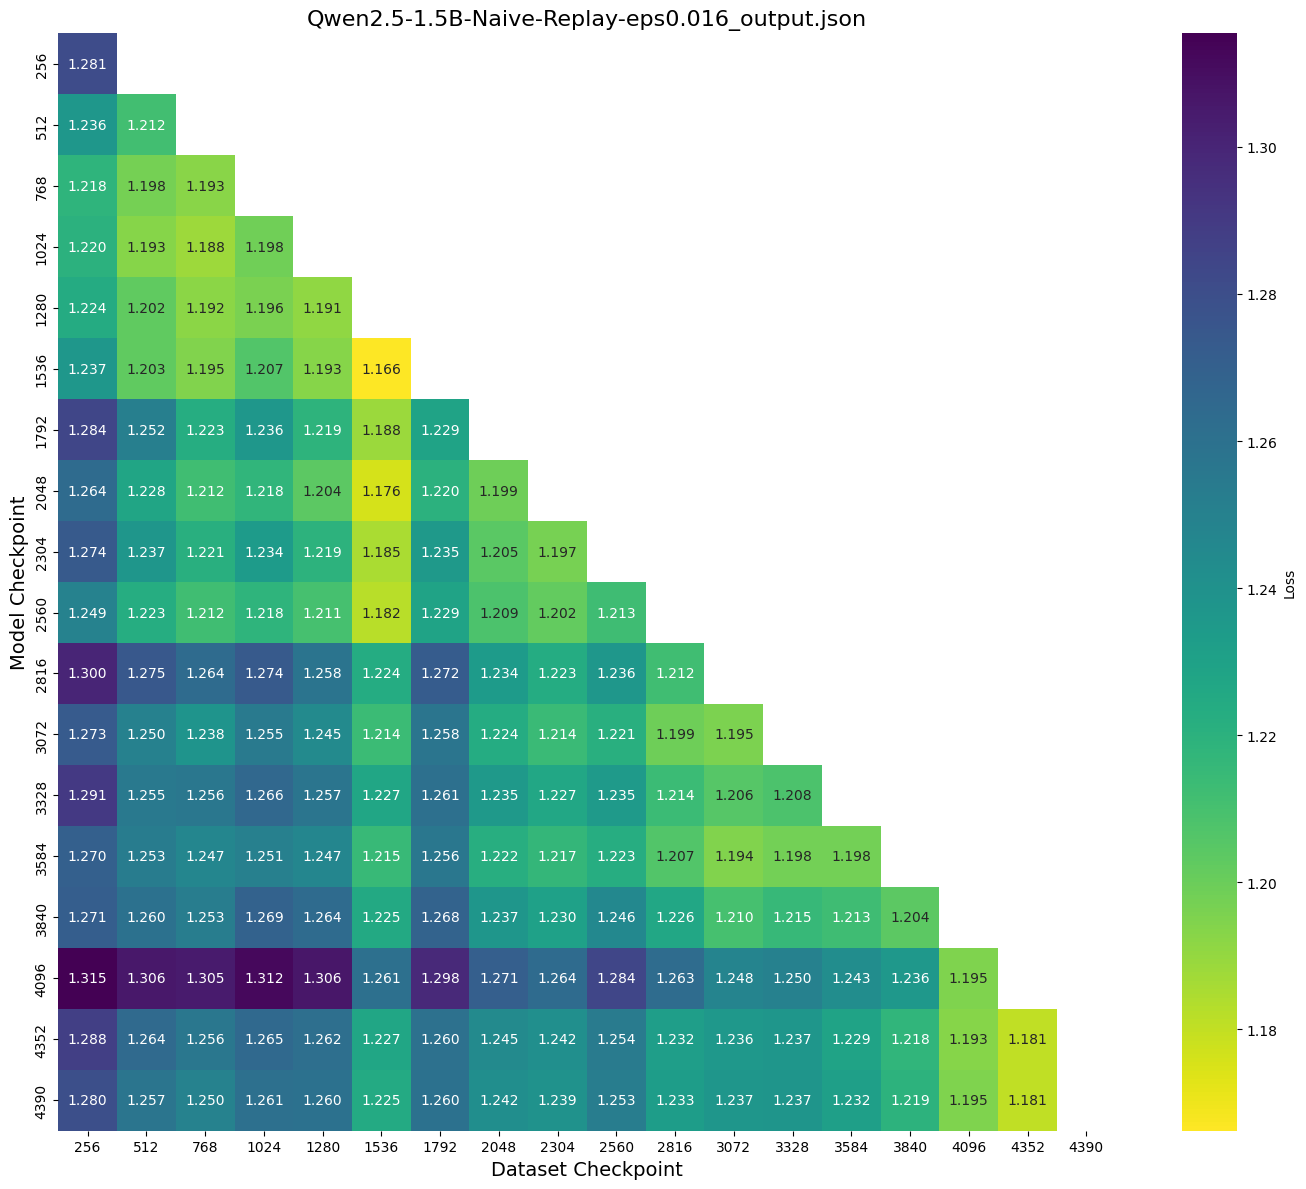

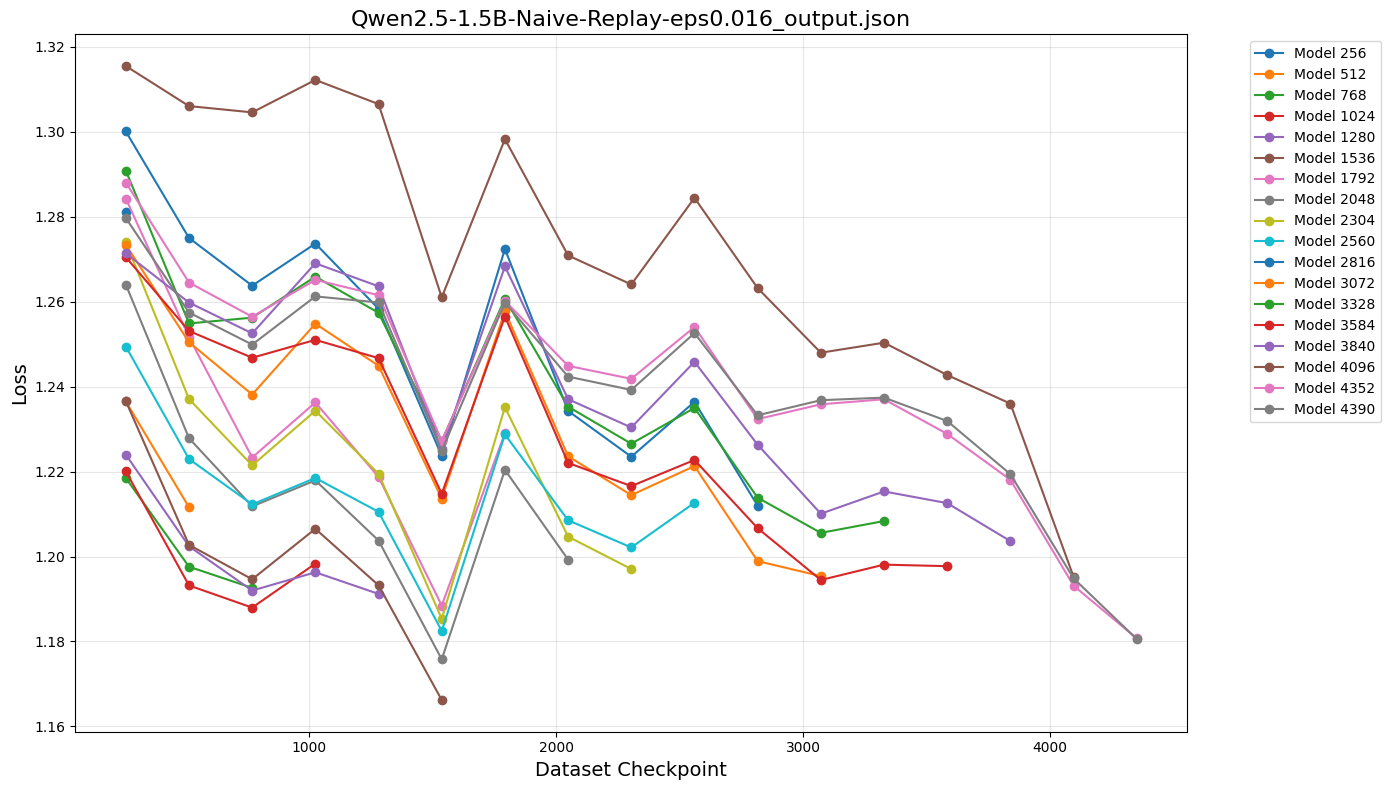

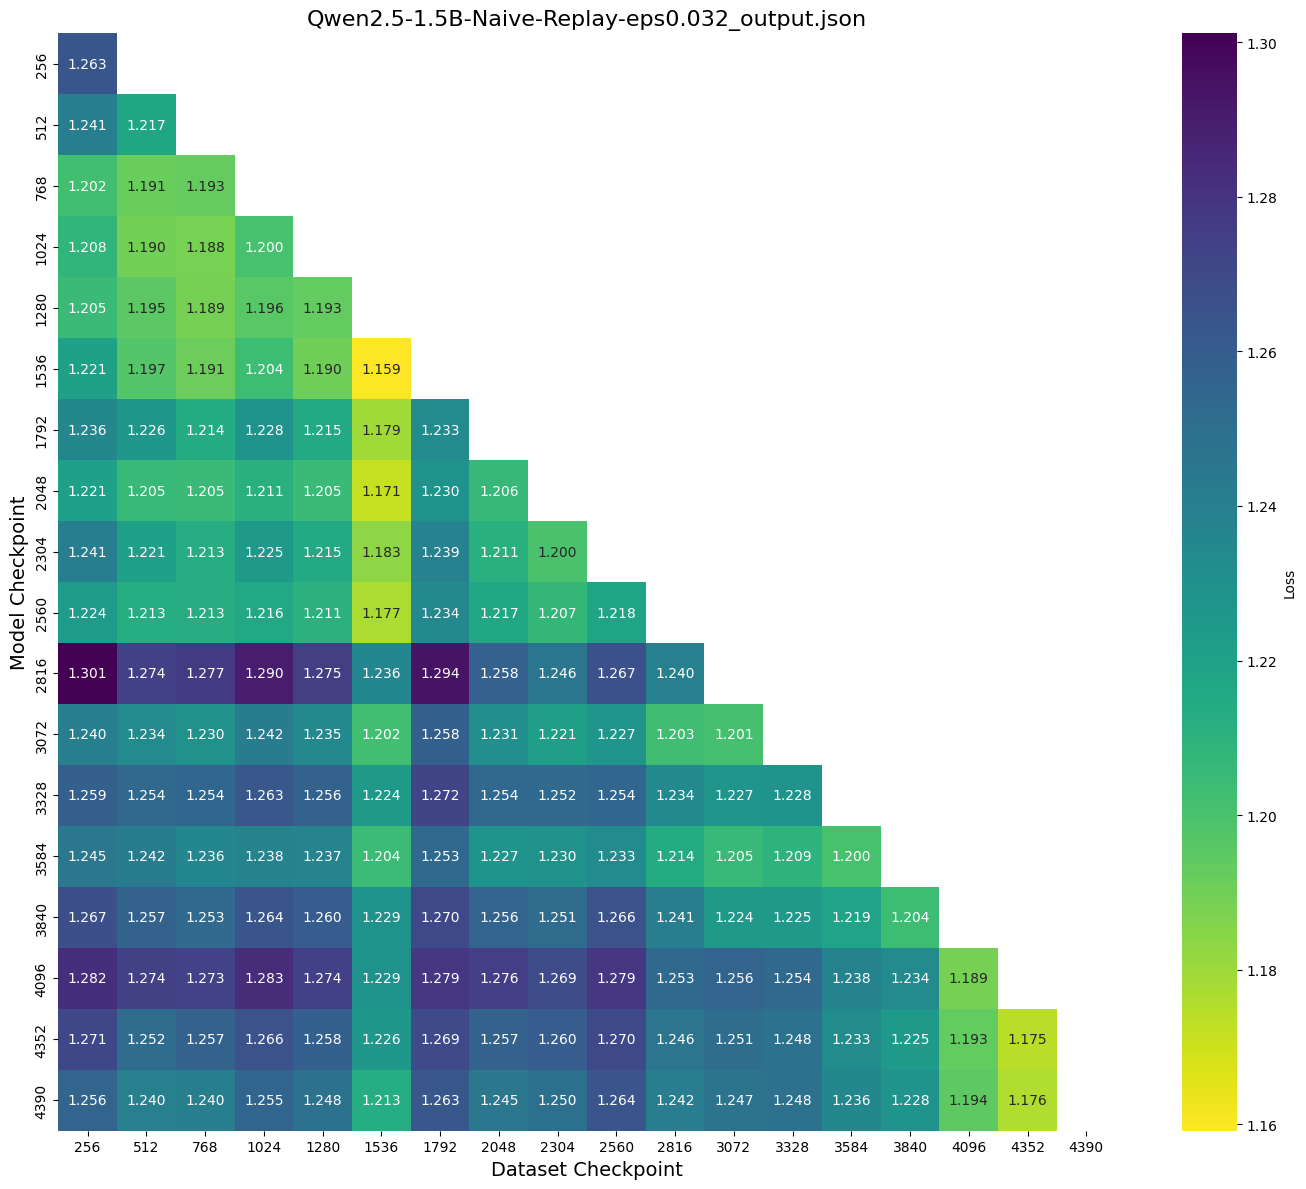

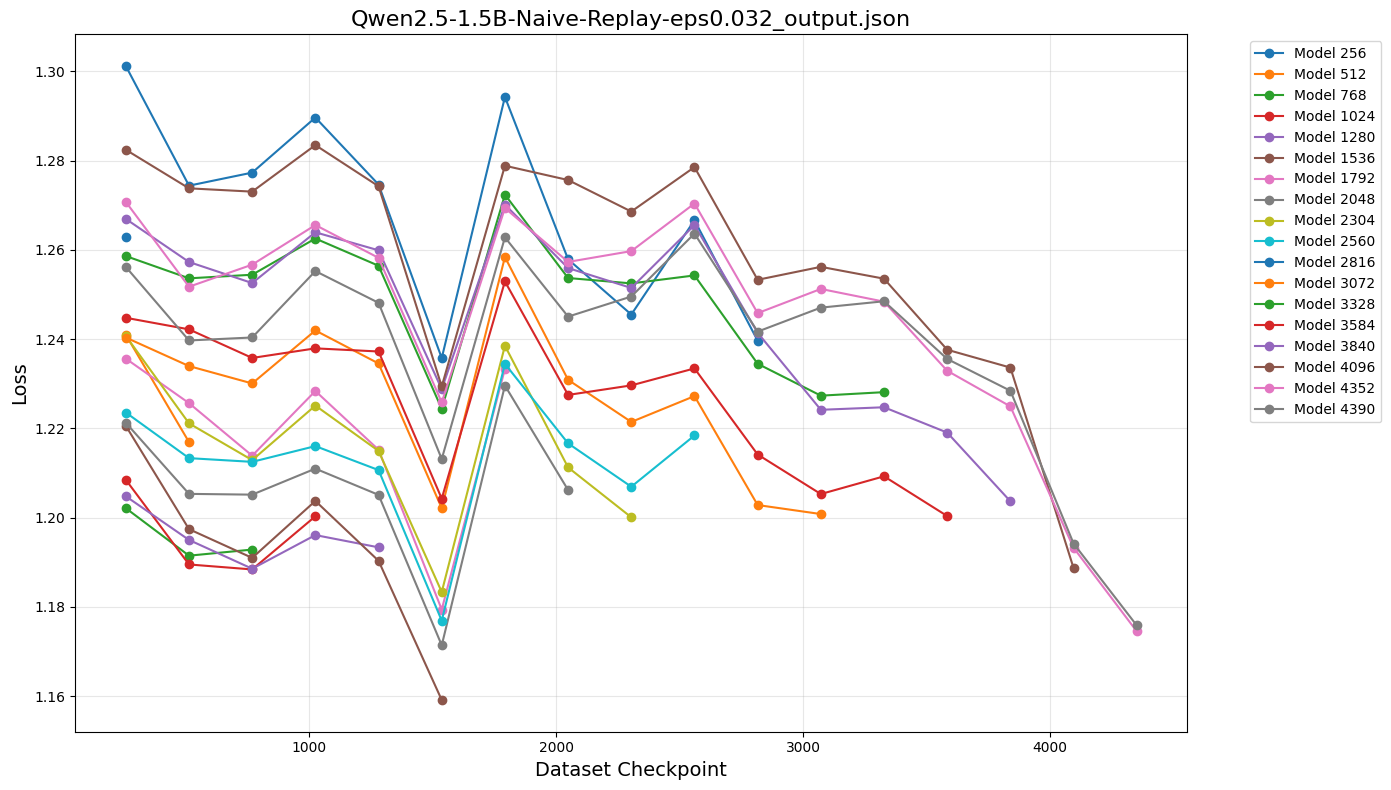

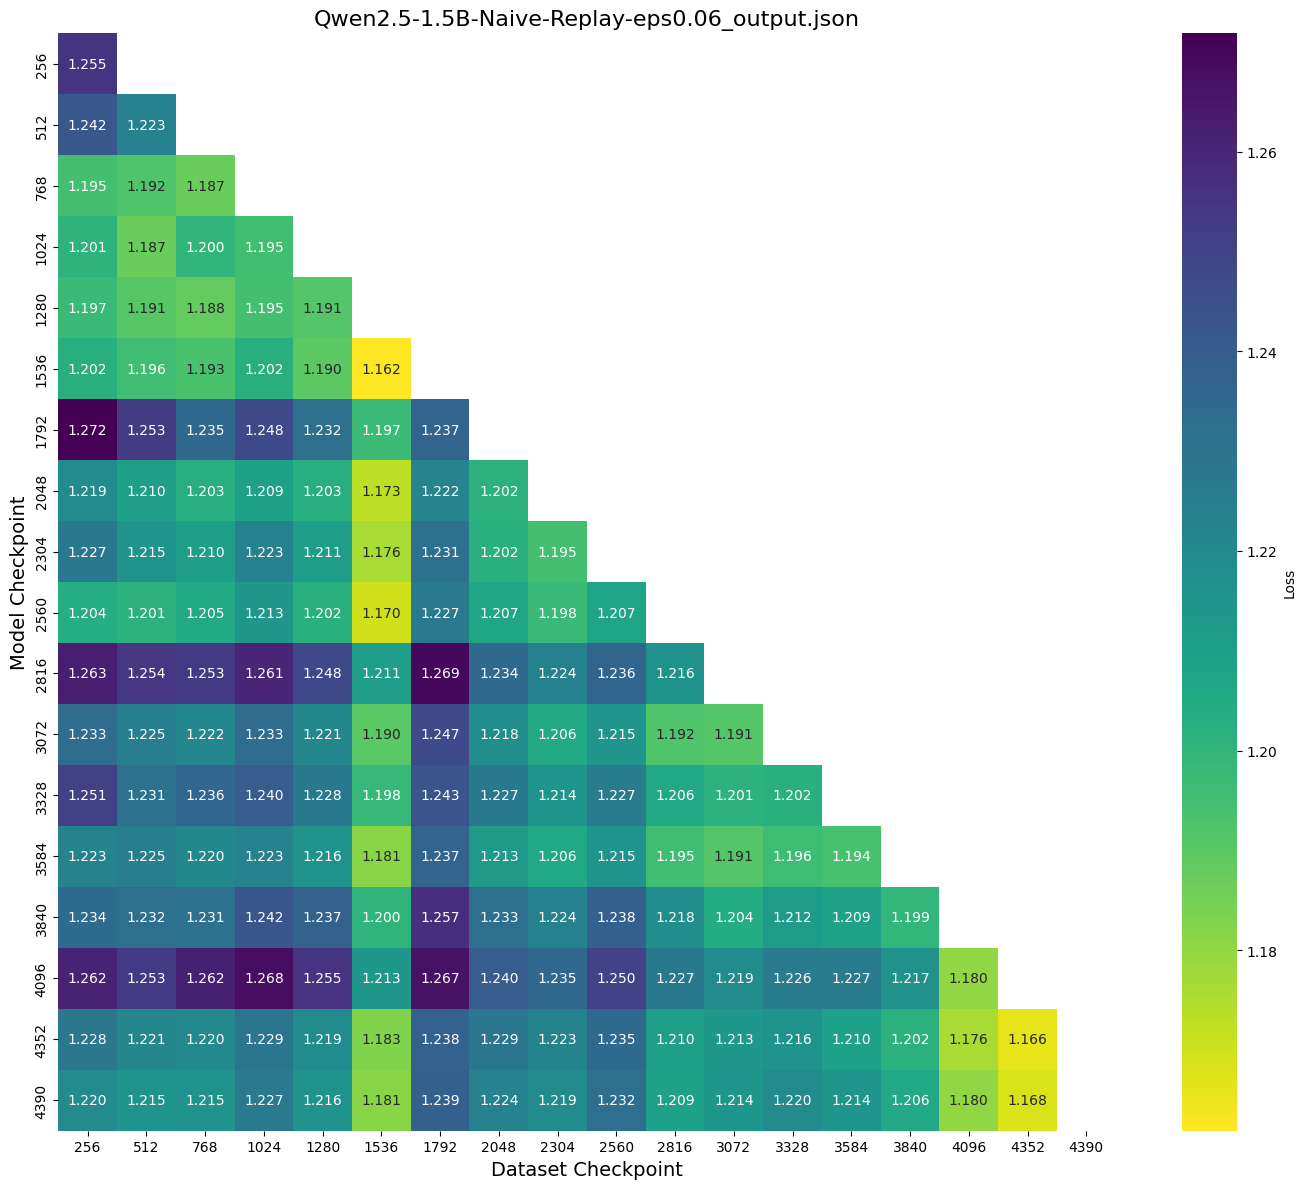

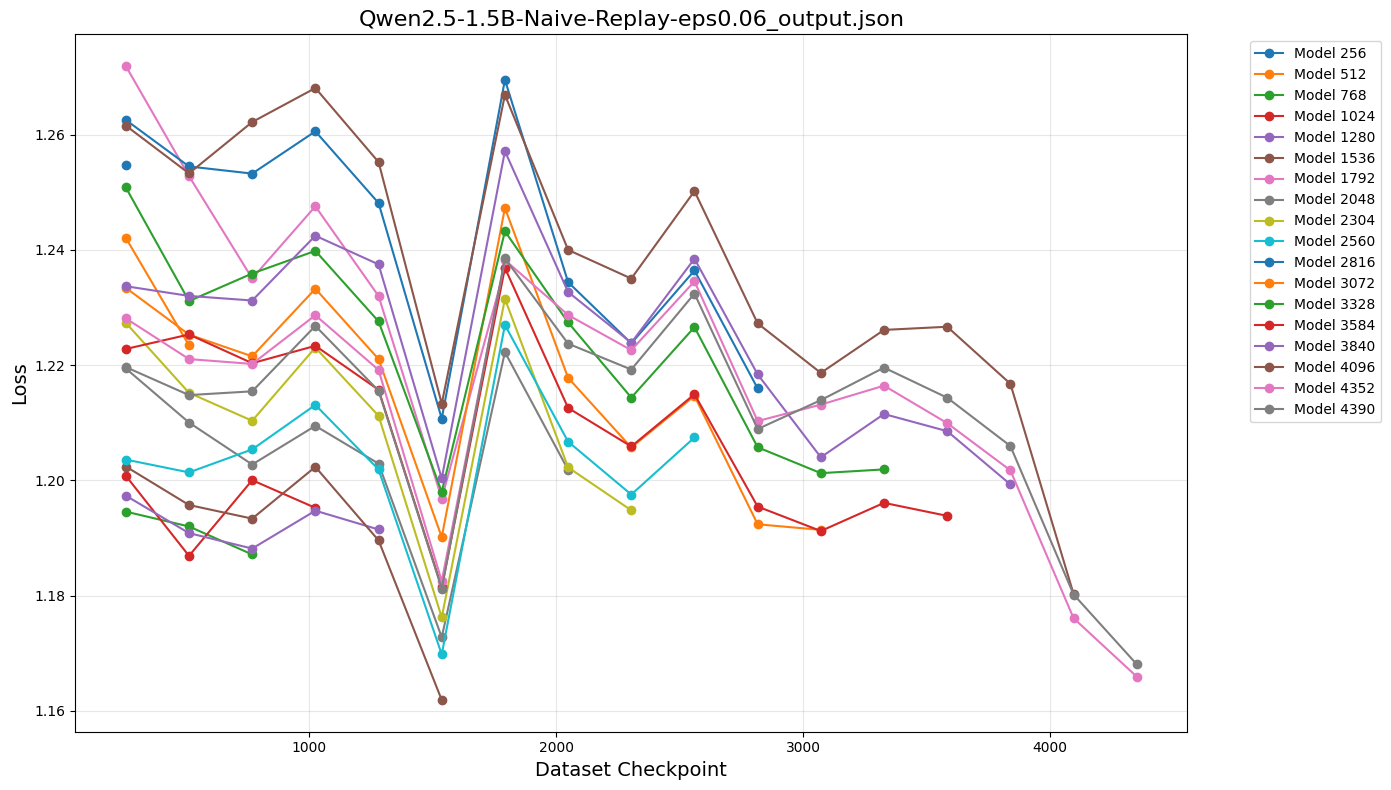

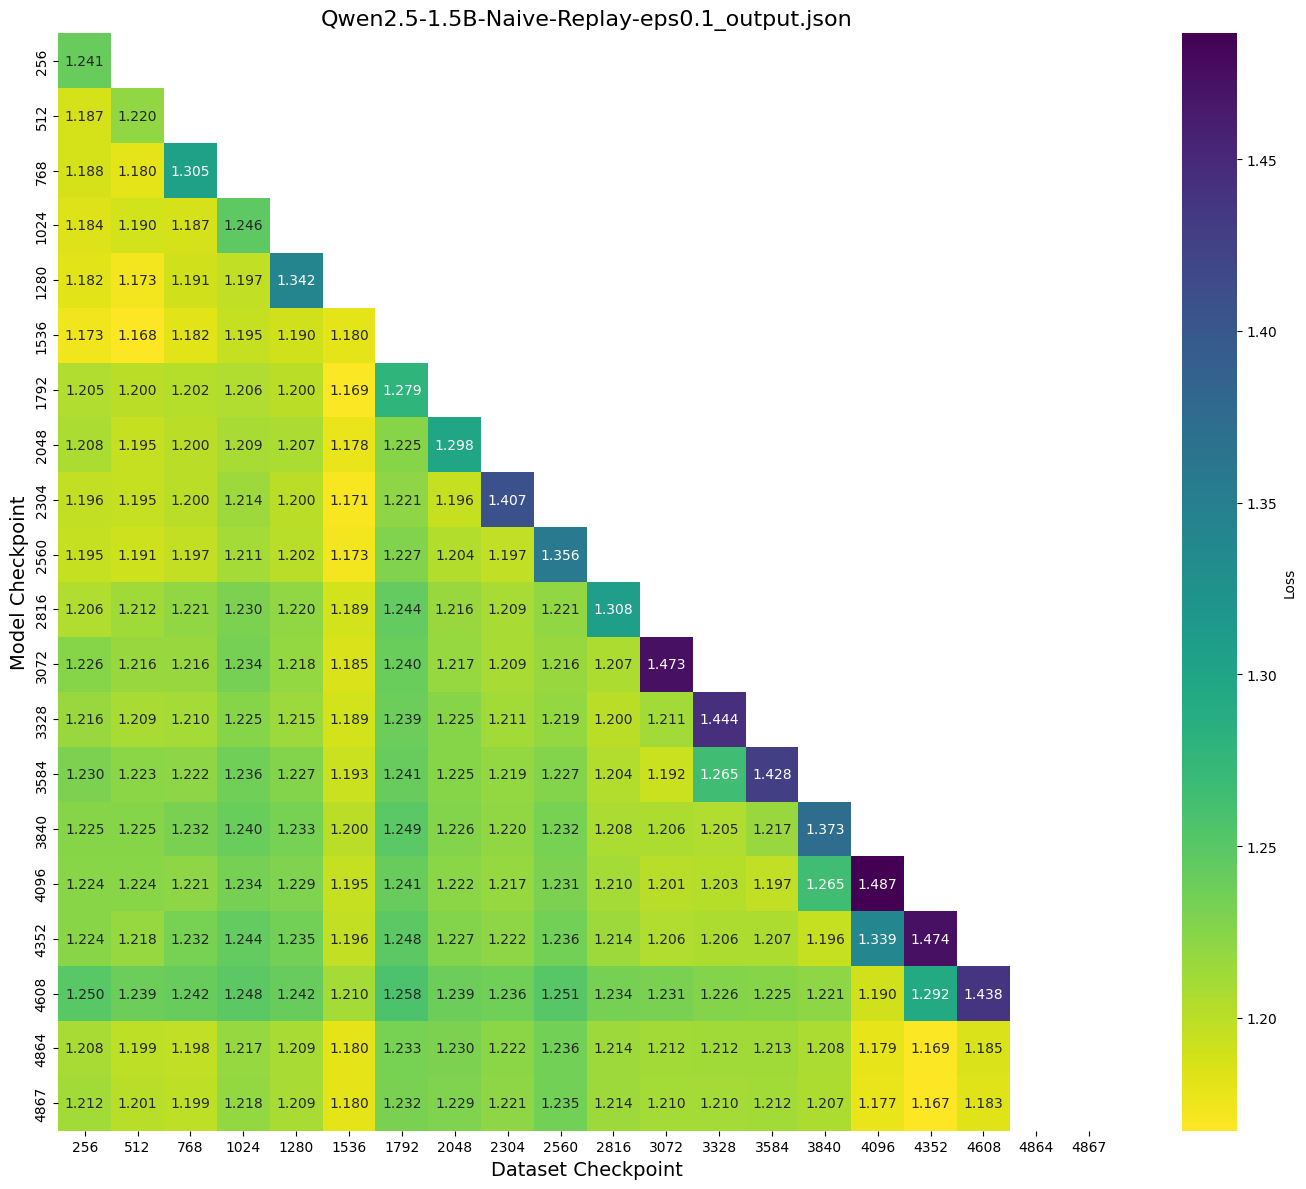

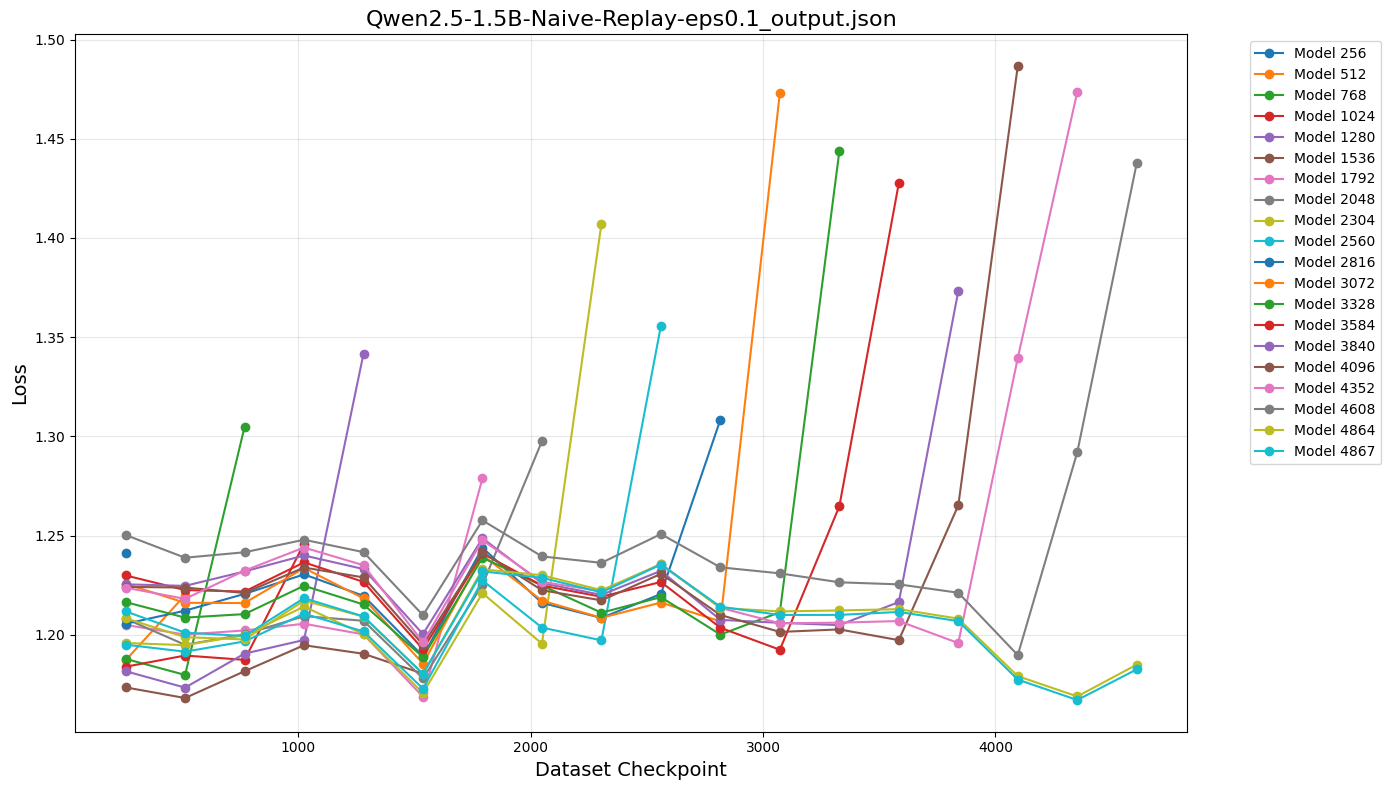

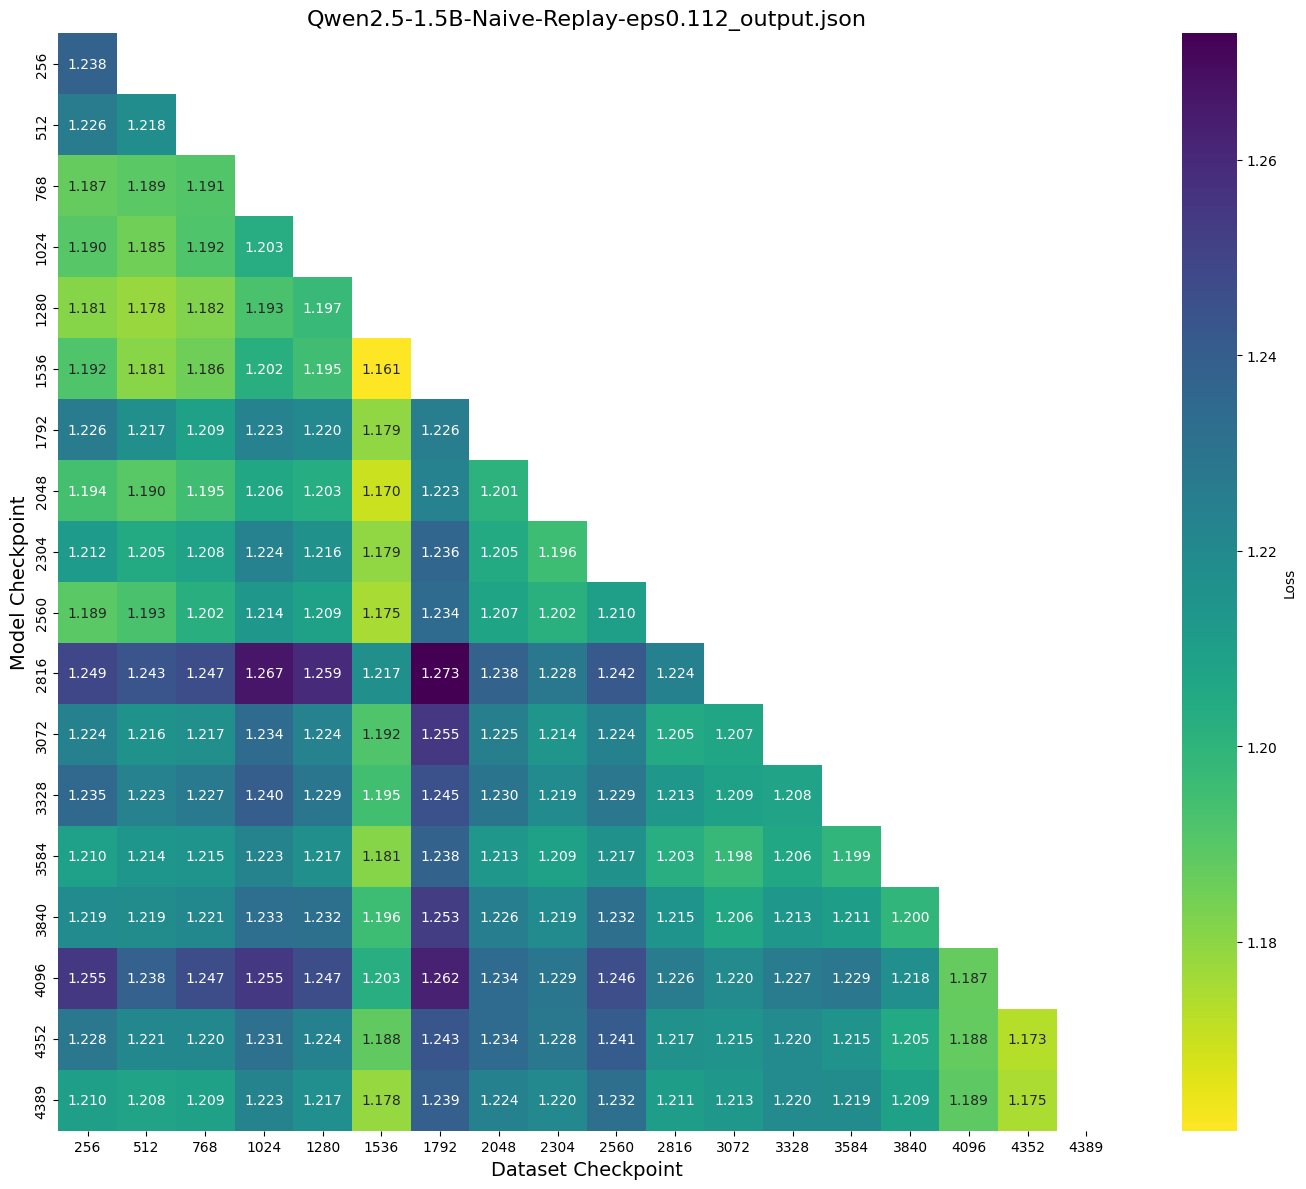

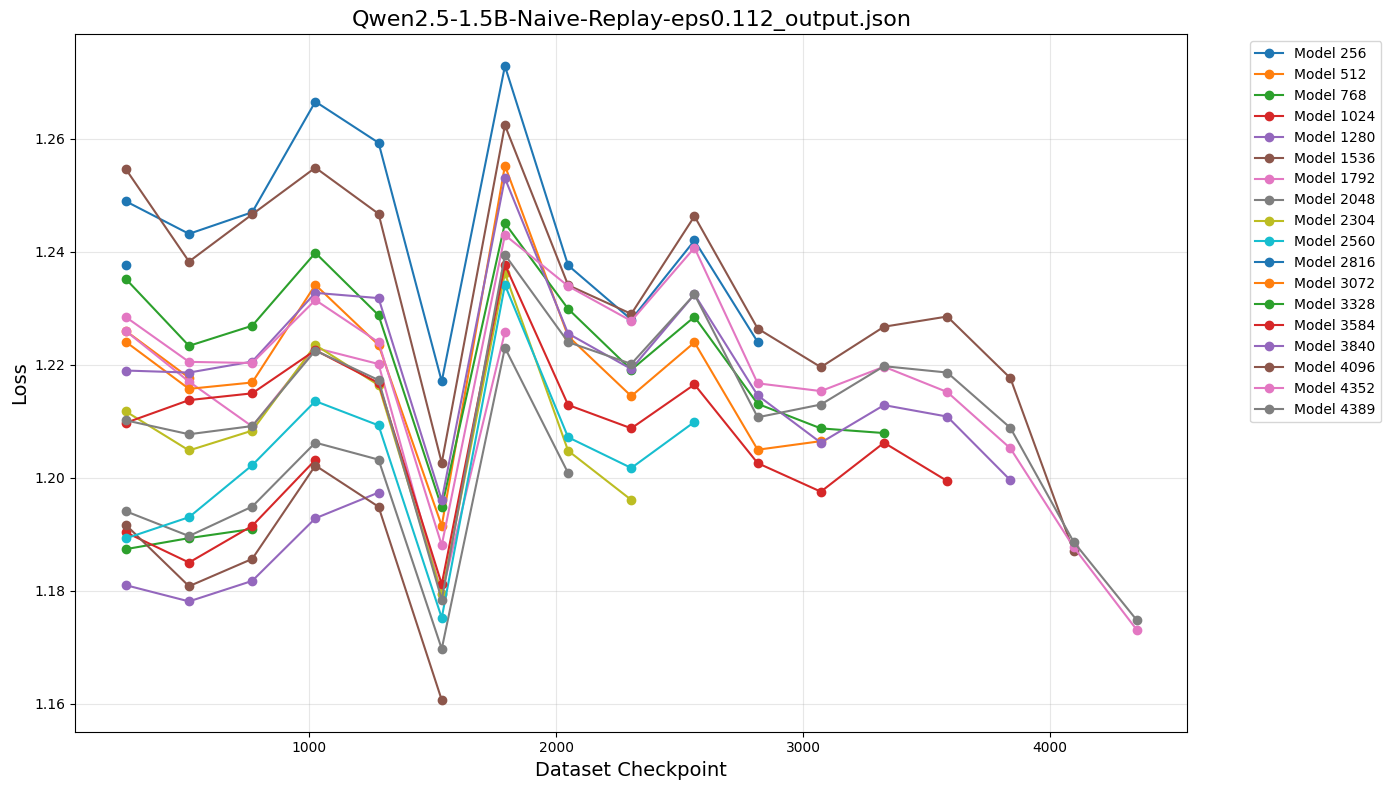

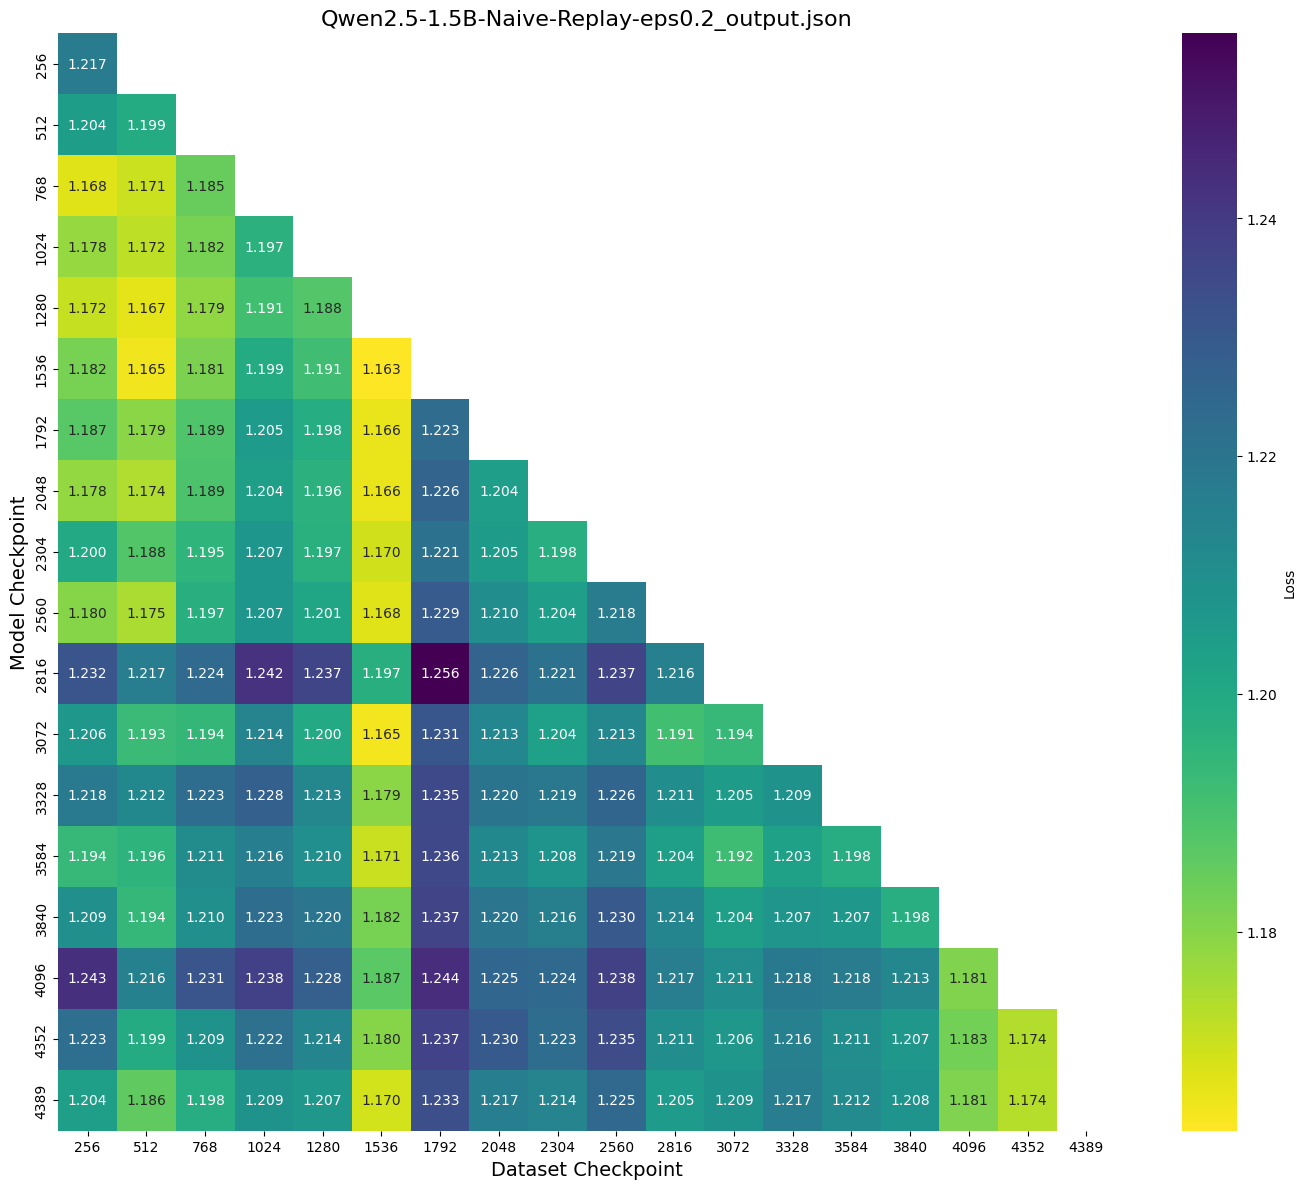

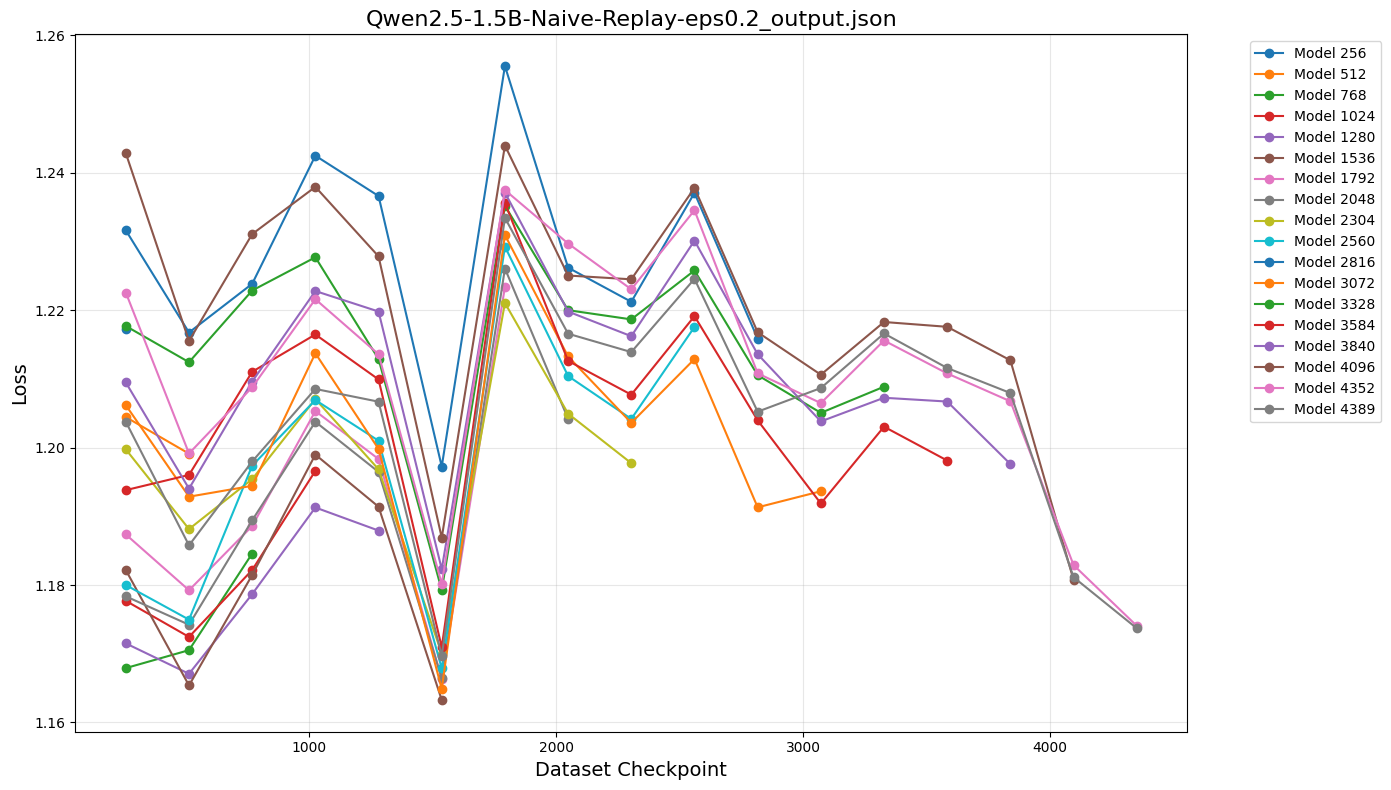

In [16]:
def plot_cp_results(path):
    model_name = path.split('/')[1]
    with open(path, 'r') as file:
        data = json.load(file)

    data_int = {int(k): {int(inner_k): v for inner_k, v in inner_dict.items()} for k, inner_dict in data.items()}

    all_checkpoints = sorted(set(int(k) for k in data.keys()).union(set(int(k) for d in data.values() for k in d.keys())))

    df = pd.DataFrame(index=all_checkpoints, columns=all_checkpoints, dtype=float)

    for model_size, datasets in data_int.items():
        for dataset_size, performance in datasets.items():
            df.loc[model_size, dataset_size] = performance

    if 4390 in df.index:
        temp_row = df.loc[4390].copy()
        df = df.drop(4390)
        df.loc[4390] = temp_row

    df = df.sort_index(axis=0).sort_index(axis=1)

    mask = df.isna()

    plt.figure(figsize=(14, 12))
    ax = sns.heatmap(df, annot=True, fmt=".3f", cmap="viridis_r", mask=mask, cbar_kws={'label': 'Loss'})

    plt.title(model_name, fontsize=16)
    plt.xlabel('Dataset Checkpoint', fontsize=14)
    plt.ylabel('Model Checkpoint', fontsize=14)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 8))

    for model_size in df.index:
        model_data = df.loc[model_size].dropna()
        plt.plot(model_data.index, model_data.values, 'o-', label=f'Model {model_size}')

    plt.xlabel('Dataset Checkpoint', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title(model_name, fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
plot_cp_results('checkpoint_results/Qwen2.5-1.5B-Naive-Replay-eps0.016_output.json')
plot_cp_results('checkpoint_results/Qwen2.5-1.5B-Naive-Replay-eps0.032_output.json')
plot_cp_results('checkpoint_results/Qwen2.5-1.5B-Naive-Replay-eps0.06_output.json')
plot_cp_results('checkpoint_results/Qwen2.5-1.5B-Naive-Replay-eps0.1_output.json')
plot_cp_results('checkpoint_results/Qwen2.5-1.5B-Naive-Replay-eps0.112_output.json')
plot_cp_results('checkpoint_results/Qwen2.5-1.5B-Naive-Replay-eps0.2_output.json')
    

In [17]:
with open('checkpoint_results/Qwen2.5-1.5B-Naive-Replay-eps0.016_output.json', 'r') as file:
    test = json.load(file)

In [23]:
max_key = sorted(test.keys(), key=lambda x: int(x))[-1]
test[max_key]

{'1024': 1.2612128257751465,
 '3840': 1.2193763256072998,
 '768': 1.2498741149902344,
 '1536': 1.2248783111572266,
 '2048': 1.2423352003097534,
 '256': 1.2796720266342163,
 '4352': 1.1805708408355713,
 '3328': 1.2373912334442139,
 '4096': 1.194855809211731,
 '1280': 1.2597787380218506,
 '3072': 1.2367842197418213,
 '2816': 1.2332336902618408,
 '3584': 1.2318816184997559,
 '2560': 1.2525781393051147,
 '512': 1.257415771484375,
 '2304': 1.2392008304595947,
 '1792': 1.2597572803497314}

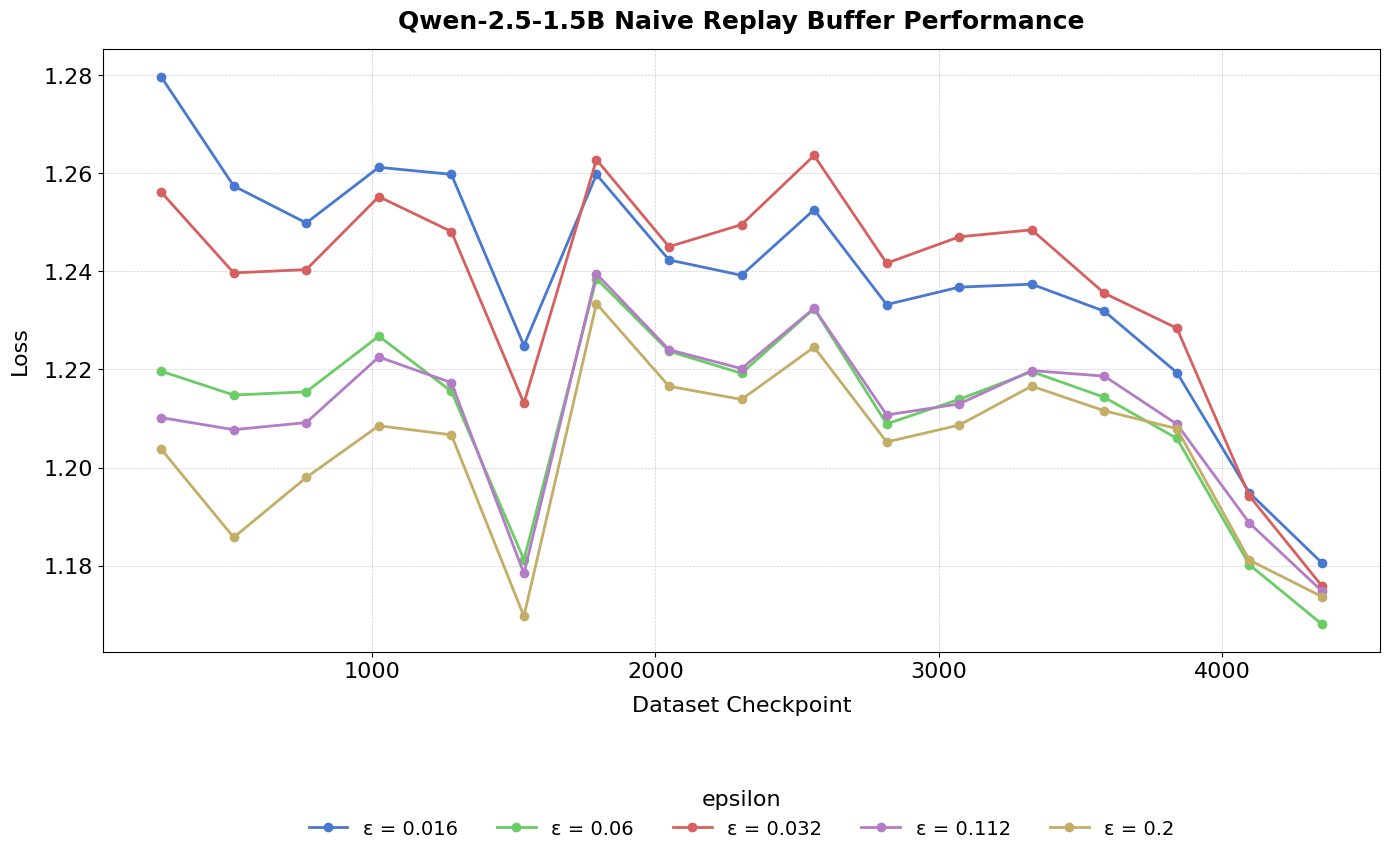

In [70]:
model_conversion = {
    'Qwen2.5-1.5B-Naive-Replay-eps0.016_output.json': 0.016,
    'Qwen2.5-1.5B-Naive-Replay-eps0.032_output.json': 0.032,
    'Qwen2.5-1.5B-Naive-Replay-eps0.06_output.json': 0.06,
    'Qwen2.5-1.5B-Naive-Replay-eps0.1_output.json': 0.1,
    'Qwen2.5-1.5B-Naive-Replay-eps0.112_output.json': 0.112,
    'Qwen2.5-1.5B-Naive-Replay-eps0.2_output.json': 0.2
}

def plot_last_cp_results(paths):
    plt.style.use('seaborn-v0_8-muted')
    fig, ax = plt.subplots(figsize=(14, 10))

    for path in paths:
        filename = path.split('/')[-1]
        eps_value = model_conversion.get(filename, filename)  # fallback to filename if missing

        with open(path, 'r') as file:
            data = json.load(file)

        # Convert string keys to integers
        data_int = {int(k): {int(inner_k): v for inner_k, v in inner_dict.items()} for k, inner_dict in data.items()}

        # Get last model checkpoint key
        last_model_cp = max(data_int.keys())
        if last_model_cp not in data_int:
            continue

        performance = data_int[last_model_cp]
        performance_series = pd.Series(performance).sort_index()

        ax.plot(
            performance_series.index,
            performance_series.values,
            marker='o',
            linewidth=2,
            label=f'ε = {eps_value}'
        )

    ax.set_xlabel('Dataset Checkpoint', fontsize=16, labelpad=10)
    ax.set_ylabel('Loss', fontsize=16, labelpad=10)
    ax.set_title('Qwen-2.5-1.5B Naive Replay Buffer Performance', fontsize=18, weight='bold', pad=15)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Legend below the plot
    legend = ax.legend(
        title='epsilon',
        loc='upper center',
        bbox_to_anchor=(0.5, -0.2),
        ncol=5,
        fontsize=14,
        title_fontsize=16,
        frameon=False
    )

    fig.tight_layout(rect=[0, 0.1, 1, 1])  # extra bottom space for legend
    plt.show()

# Call function with list of JSON result files
plot_last_cp_results([
    'checkpoint_results/Qwen2.5-1.5B-Naive-Replay-eps0.016_output.json',
    'checkpoint_results/Qwen2.5-1.5B-Naive-Replay-eps0.06_output.json',
    'checkpoint_results/Qwen2.5-1.5B-Naive-Replay-eps0.032_output.json',
    'checkpoint_results/Qwen2.5-1.5B-Naive-Replay-eps0.112_output.json',
    'checkpoint_results/Qwen2.5-1.5B-Naive-Replay-eps0.2_output.json',
])

In [72]:
def plot_training_strategies_comparison(paths_with_labels):
    plt.style.use('seaborn-v0_8-muted')
    fig, ax = plt.subplots(figsize=(14, 10))

    for path, label in paths_with_labels:
        with open(path, 'r') as file:
            data = json.load(file)

        # Convert string keys to integers
        data_int = {int(k): {int(inner_k): v for inner_k, v in inner_dict.items()} for k, inner_dict in data.items()}

        # Get last model checkpoint key
        last_model_cp = max(data_int.keys())
        if last_model_cp not in data_int:
            continue

        performance = data_int[last_model_cp]
        performance_series = pd.Series(performance).sort_index()

        ax.plot(
            performance_series.index,
            performance_series.values,
            marker='o',
            linewidth=2,
            label=label
        )

    ax.set_xlabel('Dataset Checkpoint', fontsize=16, labelpad=10)
    ax.set_ylabel('Loss', fontsize=16, labelpad=10)
    ax.set_title('Comparison of Training Strategies on Chronological Val Data', fontsize=18, weight='bold', pad=15)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Legend below the plot
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.2),
        ncol=4,
        fontsize=14,
        title='Training Strategy',
        title_fontsize=16,
        frameon=False
    )

    fig.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

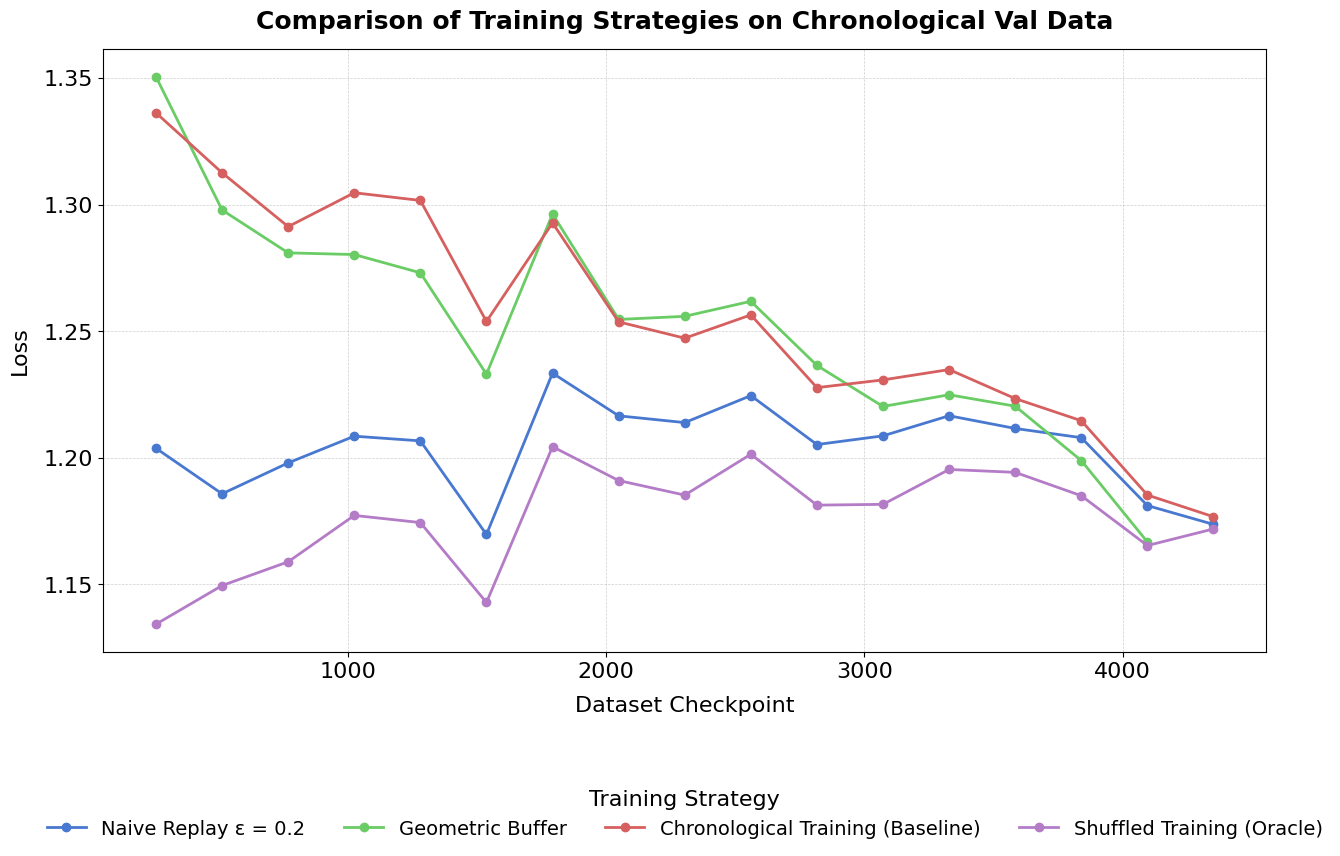

In [73]:
plot_training_strategies_comparison([
    ('checkpoint_results/Qwen2.5-1.5B-Naive-Replay-eps0.2_output.json', 'Naive Replay ε = 0.2'),
    ('checkpoint_results/Qwen2.5-1.5B-Geom-test_outputs.json', 'Geometric Buffer'),
    ('checkpoint_results/naive_chrono_results.json', 'Chronological Training (Baseline)'),
    ('checkpoint_results/shuffled_cp_results.json', 'Shuffled Training (Oracle)')
])